# Preprocessing

Steps:
* Infere data type from string data.
* Apply transformation to p-values.
* Replace NaNs with zeros.

In [1]:
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'white'

%matplotlib inline

In [2]:
def from_disk(path_to_file):
    """Reads raw .txt data from disk and returns a pandas.DataFrame."""
    
    return pd.read_csv(path_to_file , delim_whitespace=True, index_col=0)

In [3]:
def prep_data(raw_data, log_transform=False):
    """preform preprocessing of raw data."""
    
    # Convert <str> to <float>.
    data = raw_data.infer_objects()
    # Apply -log(*) transform to invert p-values mangnitude.
    if log_transform:
        transf_data = data.apply(lambda val: -np.log(val))
        transf_data.fillna(0, inplace=True)
        return transf_data
    
    else:    
        data.fillna(0, inplace=True)
        return data

In [4]:
def gen_stats(df):
    """Returns descriptive statistics."""
    
    nrows, ncols = np.shape(df.values)
    output = [
        np.max(df.values), 
        np.min(df.values), 
        np.std(df.values),
        int(nrows), int(ncols), 
        int(np.count_nonzero(df.values))
    ]
    
    return output

In [5]:
def stats_table(datasets, index=None):
    """Produces a pandas.DataFrame with descriptive 
    statistics for each dataset."""
    
    _stats = []
    for dataset in datasets:
        _stats.append(gen_stats(dataset))
        
    df = pd.DataFrame(
        _stats, index=index,
        columns=[
            'max', 'min', 'std', 'nrows', 'ncols', 'nonzeros'
        ]
    )
    
    return df

In [6]:
def gen_graphics(title, data, out_path):
    """Generate a Seaborn heatmap and write
    image to disk."""
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    sns.heatmap(
        data, robust=True, 
        cmap=plt.cm.RdBu_r, fmt='f', 
        vmin=np.min(data),
        vmax=np.max(data)
    )
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(out_path)

In [7]:
# Load raw data into memory
orig_pvalues = from_disk(
    './../../data/test/emQTL_CorrelationMatrix_unfiltered_pvalues.txt'
)
# NOTE: Transpose to (genes x CpGs).
sel_pvalues = from_disk(
    './../../data/test/emQTL_CorrelationMatrix_significant_pvalues.txt'
).T
orig_pcc = from_disk(
    './../../data/test/emQTL_CorrelationMatrix_unfiltered_PCCs.txt'
)
# NOTE: Transpose to (genes x CpGs).
sel_pcc = from_disk(
    './../../data/test/emQTL_CorrelationMatrix_significant_PCCs.txt'
).T

In [8]:
# NOTE: Unecessary since processed data is written as 
# pandas.DataFrame and thus maintains row and col labels.
datasets = {
    'orig_pvalues': orig_pvalues, 
    'sel_pvalues': sel_pvalues, 
    'orig_pcc': orig_pcc, 
    'sel_pcc': sel_pcc
}
# Write column and row labels for each dataset to txt file.
for label, data in datasets.items():
    
    with open('./../../data/data_id/id_{}.txt'.format(label), 'w') as outfile:
        outfile.write('{0}\n'.format(label))
        outfile.write('{0}\n'.format(list(data.index)))
        outfile.write('{0}\n'.format(list(data.columns)))

In [9]:
# Processing of p-values .
pvalues_prep = {
    'original': prep_data(orig_pvalues, log_transform=True), 
    'selected': prep_data(sel_pvalues, log_transform=True)
}

In [10]:
# Processing of PCCs.
pcc_prep = {
    'original': prep_data(orig_pcc, log_transform=False),
    'selected': prep_data(sel_pcc, log_transform=False)
}

## Collecting target data characteristics

Write the characteristics of experimental data to file in order to generate synthetic test data resembling the reference data.

In [11]:
df = stats_table(
    [
        pvalues_prep['original'], pvalues_prep['selected'],
        pcc_prep['original'], pcc_prep['selected']
    ],
    index=[
        'orig_prep_pvalues', 'sel_prep_pvalues',  
        'orig_prep_pcc', 'sel_prep_pcc'
    ]
)
df.to_csv(
    './../../data/data_id/data_characteristics.csv', 
    sep='\t', encoding='utf-8'
)
# NOTE: The min p-value is influenced by replacing NaN := 0.
print('Statistics: \n{}'.format(df))

Statistics: 
                         max           min       std  nrows  ncols  nonzeros
orig_prep_pvalues  73.435290  7.079401e-09  5.889983   2664  27561  73422504
sel_prep_pvalues   73.435290  0.000000e+00  2.897937   2664  27561    739608
orig_prep_pcc       0.852443 -8.669647e-01  0.323260   2664  27561  73422504
sel_prep_pcc        0.852443 -8.669647e-01  0.063930   2664  27561    739608


## Visualizing processed data

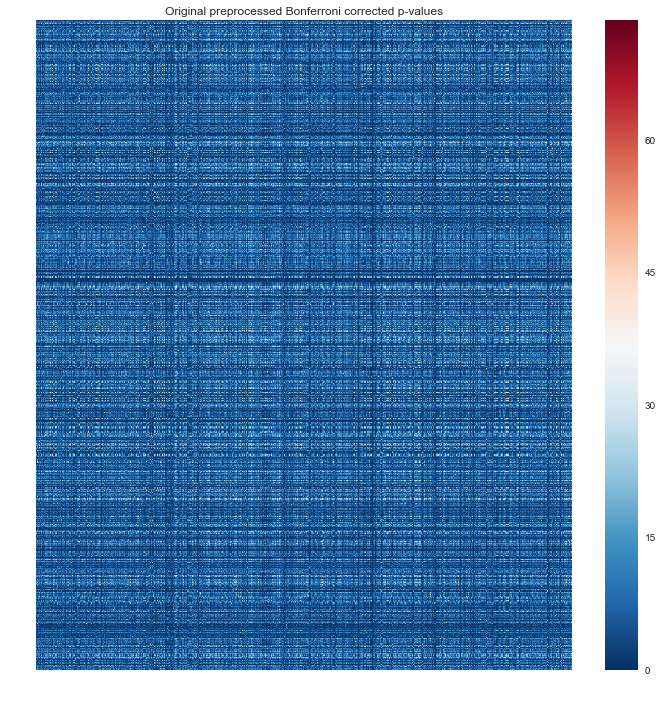

In [13]:
gen_graphics(
    'Original preprocessed Bonferroni '
    'corrected p-values', 
    pvalues_prep['original'].values, 
    './../../data/imgs/org_pvalues.png'
)

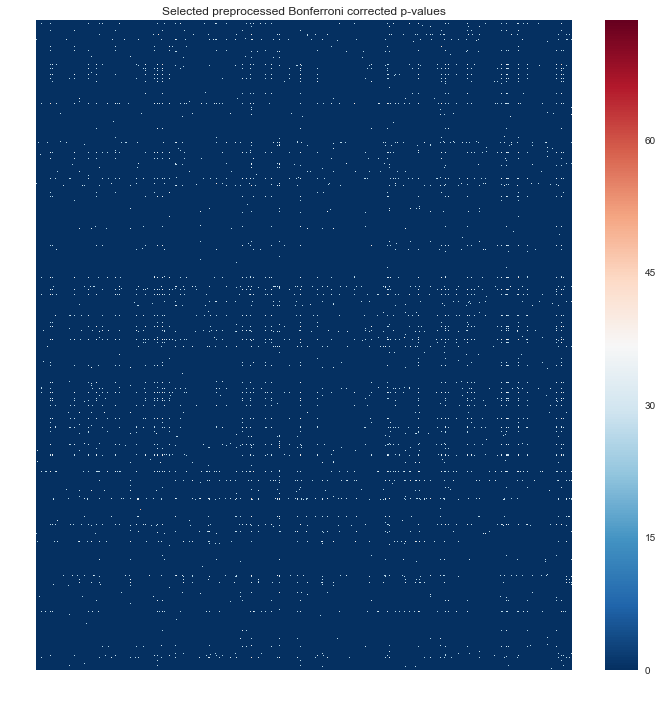

In [14]:
gen_graphics(
    'Selected preprocessed Bonferroni '
    'corrected p-values', 
    pvalues_prep['selected'].values, 
    './../../data/imgs/sel_pvalues.png'
)

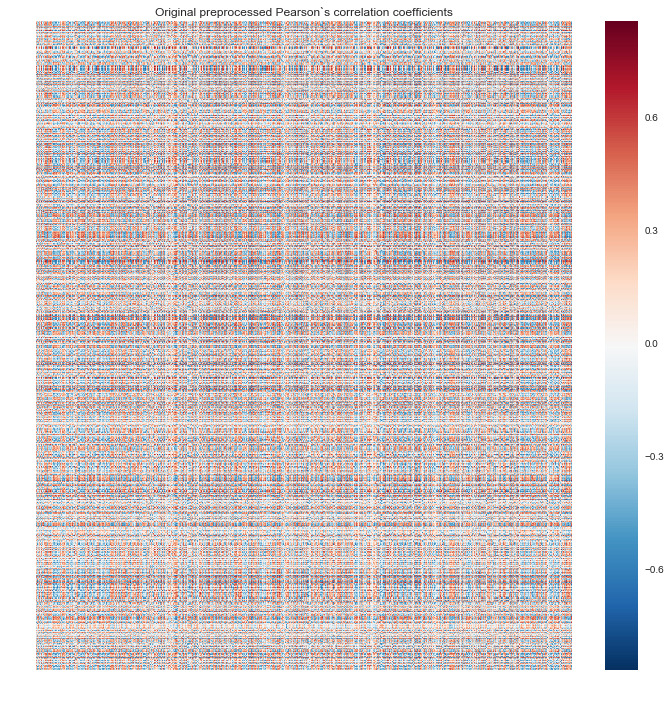

In [15]:
gen_graphics(
    'Original preprocessed Pearson`s '
    'correlation coefficients', 
    pcc_prep['original'].values, 
    './../../data/imgs/org_pcc.png'
)

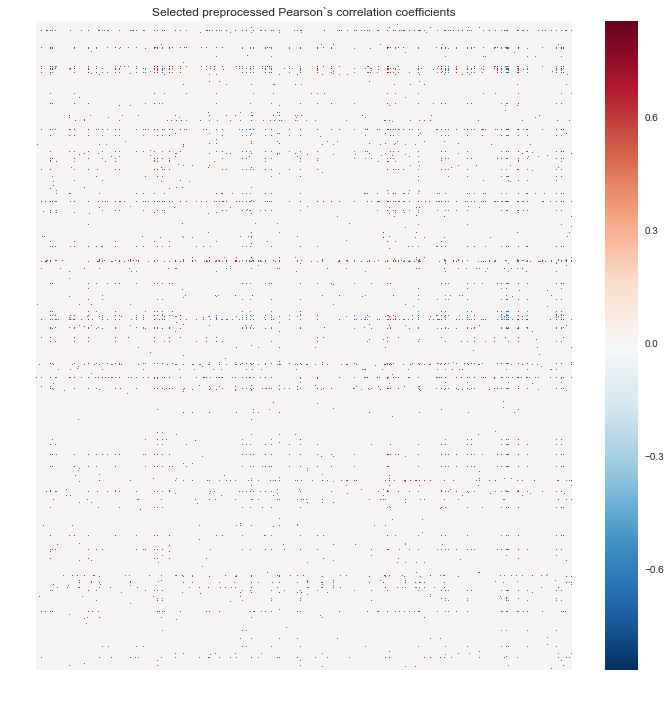

In [16]:
gen_graphics(
    'Selected preprocessed Pearson`s '
    'correlation coefficients', 
    pcc_prep['selected'].values, 
    './../../data/imgs/sel_pcc.png'
)

## Saving processed data to disk

In [17]:
def to_disk(path_to_file, data):
    
    data.to_csv(
        path_to_file, sep=',', 
        columns=list(data.columns), index=list(data.index)
    )

In [18]:
pvalue_data = {
    './../../data/train/orig_pvalues_prep.csv': pvalues_prep['original'],
    './../../data/train/sel_pvalues_prep.csv': pvalues_prep['selected']
}
for path, dataset in pvalue_data.items():
    to_disk(path, dataset)

In [19]:
pcc_data = {
    './../../data/train/orig_pcc_prep.csv': pcc_prep['original'],
    './../../data/train/sel_pcc_prep.csv': pcc_prep['selected']
}
for path, dataset in pcc_data.items():
    to_disk(path, dataset)